# Lasso regression

LASSO (Least Absolute Shrinkage & Selection Operator) regression works by dropping weak and ineffective features from the model.  It is useful when the input data contains a large amount of predictors (1k - 100k+) and need to optimize processor time or when simpler, more interpretable solutions are required.  The model effectively acts as a feature selection mechanism, which can prevent overfitting.

In ridge regression, parameter estimates are shrunk but they never quite reach 0.  Lasso forces the smallest parameters to be equal to zero, effectively dropping them from the model.  The cost function is very similar to ridge:

$$ \sum_{i=1}^n(y_i - (\alpha + \beta x_i))^2 + \lambda\sum_{j=1}^p|{\beta_j}| $$

Instead of penalizing the sum of squared coeffiecient, as in ridge, lasso penalizes by the sum of the absolute values of the coefficients (called **L1 regularization**).  The penalty doesn't increase as swiftly in this case.  

Because lasso regression forces features to zero, the derivatives of these features will be undefined. Thus, the gradient descent algorithm will be unable to handle the multi-dimensional surface created by lasso.  Instead, lasso regression models are optimized using a coordinate descent algorithm.


### Coordinate Descent Algorithm

Coordinate descent algorithms work as follows:

Pick some starting values for $\beta$, often 0.  Then for each feature $j$ in $\beta$:
- Predict the outcome using all features besides $j$.
- See how the residuals of $\beta_{-j}$ correlate with $j$ (this correlation is defined as $\rho_j$.
- If $\rho_j$ falls within $|\lambda|$ of 0, set $\beta_j = 0$
- If $\rho_j < \frac{\lambda}2$ set $\beta_j == \rho_j + \frac{\lambda}2$
- If $\rho_j > \frac{\lambda}2$ set $\beta_j == \rho_j - \frac{\lambda}2$

The algorith will iterate through all parameters and cycle through this process until the maximum difference between parameter estimates for the current cycle and previous cycle is less than a pre-determined threshold $tol$.  In SKlearn, $tol$ defaults to 0.0001.  During the course of this algorithm each feature will shrink a bit from the previous iteration, unless it has already been set to 0.

In summary, lasso fits a model using all parameters but one and sees if that fit is "good enough" (e.g. less than $|\lambda|$). If it is, indeed, good enough, the model drops that feature by setting it's coefficient to 0.  If it isn't, then it shrinks the coefficient a bit.  This continues until the change in model residuals is less than a predetermined threshold.  Effectively lasso models protect against overfitting by shrinkage and creating sparsity -- many parameters are set to 0.



### Lasso Model Example

We'll now run through a lasso model using the same dataset from the ridge models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
# Load the data & drop the index column
df = pd.read_csv(
    'https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/credit-card-defaults.csv'
).iloc[:,1:].dropna()

# Recode strings to numeric.
df['default'] = np.where(df['default']=='Yes', 1, 0)
df['student'] = np.where(df['student']=='Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)
# scaledbalance = preprocessing.scale(df['balance'])
# df['balance'] = scaledbalance
# scaledincome = preprocessing.scale(df['income'])
# df['income'] = scaledincome

# Define the training and test sizes.
trainsize = df.shape[0] // 2
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

Y_train = df_train['income'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Make some new features to capture potential quadratic and cubic
# relationships between solar radiation and day or temperature.
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Test the simpler model with smaller coefficients.
Y_test = df_test['income'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]

# Test the more complex model with larger coefficients.
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]


/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  # Remove the CWD from sys.path while we load stuff.


In [3]:
# Instantiate a lasso model for the simple training set
lass = linear_model.Lasso(alpha=0.35)
lassfit = lass.fit(X_train, Y_train)
simpleparams = np.append(lassfit.coef_, lassfit.intercept_)

print('R^2 simple model: \n', lass.score(X_train, Y_train), '\n')
print('Simple model parameter estimates: \n', simpleparams)
print('\n')

# Instantiate a lasso model for the complex training set
lassBig = linear_model.Lasso(alpha=0.35)
lassBig.fit(X_train2, Y_train)
bigparams = np.append(lassBig.coef_, lassBig.intercept_)

print('R^2 complex model: \n', lassBig.score(X_train2, Y_train), '\n')
print('Complex model parameter estimates: \n', bigparams)

R^2 simple model: 
 0.450062579301185 

Simple model parameter estimates: 
 [-0.         -0.40657726 -0.          0.00114596]


R^2 complex model: 
 0.44363376712897096 

Complex model parameter estimates: 
 [ 0.00000000e+00 -3.89351238e-01  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -2.77688887e-04
 -7.09158792e-07  3.48711577e+00]


Both models get approximately the same answer.  The complex model ended up dropping 60% of the input features.

In [4]:
print(lass.score(X_test, Y_test))
print(lassBig.score(X_test2, Y_test))

0.44553225151184195
0.4380466345914476


Each model shows similar performance on the test data set which suggests that they are not overfit to the training data.

/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.828186e-17
  overwrite_a=True).T
/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.155867e-17
  overwrite_a=True).T
/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.489076e-17
  overwrite_a=True).T
/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal conditi

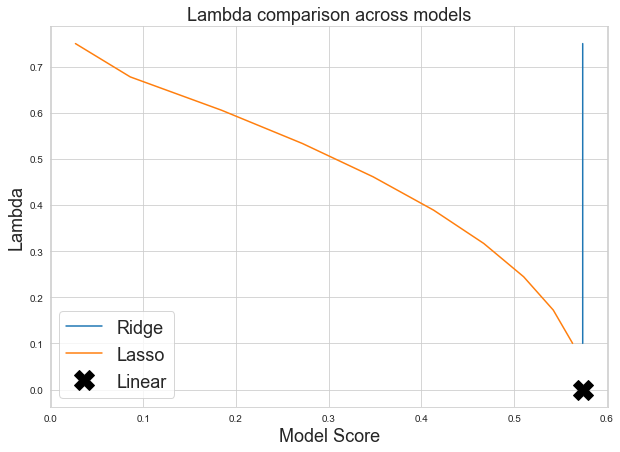

In [5]:
# Evaluating a range of lambda values
l_scores = []
r_scores = []
lamb = []
lambrange = np.linspace(0.1,.75,10)

for lambd in lambrange:
    lasso = linear_model.Lasso(alpha=lambd)
    lasso.fit(X_train2, Y_train)
    l_scores.append(lasso.score(X_train2, Y_train))
    
    ridge = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridge.fit(X_train2, Y_train)
    r_scores.append(ridge.score(X_train2, Y_train))
    
    lamb.append(lambd)

model_eval = pd.DataFrame({
    'lambda': lamb,
    'lasso': l_scores,
    'ridge': r_scores
})
model_eval.sort_values('lambda')

linregr = linear_model.LinearRegression().fit(X_train2, Y_train)

plt.figure(figsize=(10,7))
plt.plot(model_eval['ridge'], model_eval['lambda'])
plt.plot(model_eval['lasso'], model_eval['lambda'])
plt.plot(linregr.score(X_train2, Y_train), 0, 'kX', markersize=20)
plt.title('Lambda comparison across models', size=18)
plt.xlabel('Model Score', size=18)
plt.ylabel('Lambda', size=18)
plt.legend(['Ridge', 'Lasso', 'Linear'], fontsize=18)
plt.show()